## MIMOC Data for non-Oceanographers

I'd like to look for RAD loci associated with thermal clines in my Korean populations of Pacific cod. To do that, I first need oceanography data, which I am downloading from the [MIMOC database](https://www.pmel.noaa.gov/mimoc/#netCDF). 

MIMOC provides "Pressure-gridded global monthly x 0.5° x 0.5° netCDF files including pressure, longitude, and latitude vectors as well as data matrices for salinity and temperature (always absolute salinity and conservative temperature, and sometimes also practical salinity and potential temperature)."

So the first thing that I need to do is figure out how to work with a `netCDF` file. 

<br>


<br>

### Python package `netCDF`

The script [`mimoc2.py`](https://github.com/mfisher5/PCod-Compare-repo/blob/master/analyses/environmental/mimoc2.py) is from Rosalind Echols, UW Oceanography. The script uses the `netCDF` python package.
<br>
The original script was written for python 3.x; several packages (`gsw`) were not available for python 2.7, so I had to install older (deprecated) versions of those packages. Any warning messages are probably a result of using deprecated packages.

<br>

#### Installing dependencies without Anaconda

To use the `netCDF` python package, the following must be installed:
- Numpy
- [`Cython`](http://cython.org/) 
- [`setuptools`](https://pypi.org/project/setuptools/)
- [`HDF5 C library` v. 1.8.4-patch1 or higher]() 
- [`netCDF-C 4.6.1`](https://github.com/Unidata/netcdf-c/releases) 


More details and specific installation instructions for each package can be found on the [`netcdf4` github page](http://unidata.github.io/netcdf4-python/). 


#### Installing dependencies with Anaconda
In the terminal, from root directory (~)
- Cython: `conda install cython`
- update setuptools: `python -m pip install --upgrade pip setuptools wheel`
- netCDF-C v4.x: `conda install -c anaconda netcdf4`
- basemap: `conda install -c anaconda basemap`
- gsw: `pip install gsw==3.0.1` <-- Note that the most up to date version of `gsw`, a package to implement the thermodynamic equation of seawater, requires Python 3.5 or above
- cmocean: `pip install cmocean`

I did not have to install HDF5, as it was already in Anaconda

<br>

#### `Data` Object Type

The netCDF file is read in as a dictionary, with the following keys: ['LATITUDE', 'PRESSURE', 'CONSERVATIVE_TEMPERATURE', 'LONGITUDE', 'ABSOLUTE_SALINITY']

<br>
#### Testing the Script

In [1]:
cd ../analyses/environmental/

/mnt/hgfs/PCod-Compare-repo/analyses/environmental


/home/mfisher5/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


('You are looking at a depth of ', 5.0)
CONSERVATIVE_TEMPERATURE


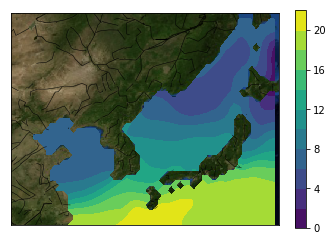

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import gsw
import cmocean

def import_data(file_name):
    '''This function works regardless of the file called as long as a list of 
    variables can be identified easily in the file.'''
    
    fh = Dataset(file_name, mode = 'r')
    data = {}
    
    for vname in list(fh.variables):
        data[str(vname)] = fh.variables[vname][:]
        
    fh.close()
            
    return data


def lat_lon_indices(latitudes,longitudes,latlonrange):
    '''This function identifies the index values for latitude and longitude
    that correspond to the desired bounds for studying a particular region so 
    that the data can be sliced before processing. It returns data in the form
    [lon_min,lon_max,lat_min,lat_max] based on a latlonrange input of the
    same value.'''
    
    index=np.zeros(4,dtype='int') 
    
    index[0] = int(next(i for i,j in enumerate(longitudes) if j == latlonrange[0]))
    index[1] = int(next(i for i,j in enumerate(longitudes) if j == latlonrange[1]))
    index[2] = int(next(i for i,j in enumerate(latitudes) if j == latlonrange[2]))
    index[3] = int(next(i for i,j in enumerate(latitudes) if j == latlonrange[3]))
                            
    return index


#MIMOC VARIABLES: ['LATITUDE', 'PRESSURE', 'POTENTIAL_TEMPERATURE', 'LONGITUDE', 'SALINITY']
#OR:
    #MIMOC VARIABLES: ['LATITUDE', 'PRESSURE', 'CONSERVATIVE_TEMPERATURE', 'LONGITUDE', 'ABSOLUTE_SALINITY']
#Shape of salinity: (81, 341, 720) = depth, latitude, longitude

filename='MIMOC_Z_GRID_v2.2_CT_SA_month02.nc.gz'

#import data:
data=import_data(filename)


#define the latitude-longitude range you want to look at:
llrange=[115,145,30,50]  #example: [120,135,30,40] captures the Korean Peninsula area

#find the relevant section of the data to look at based on your latitude/longitude range
ll_index=lat_lon_indices(data['LATITUDE'],data['LONGITUDE'],llrange)


fig=plt.figure()
m = Basemap(llcrnrlon=data['LONGITUDE'][ll_index[0]],llcrnrlat=data['LATITUDE'][ll_index[2]],
            urcrnrlon=data['LONGITUDE'][ll_index[1]],urcrnrlat=data['LATITUDE'][ll_index[3]],projection='mill')
x,y=np.meshgrid(data['LONGITUDE'][ll_index[0]:ll_index[1]],data['LATITUDE'][ll_index[2]:ll_index[3]])

#make a contour plot of the data you want to look at; you'll need to give it an index for the pressure, 
#which I think is spaced out by 5 meters near the surface. Therefore, if you pick 0 for plevel, you'll get 0m,
#1 for plevel is 5m, 2 for plevel is 10m, and so on. 
plevel=1
print('You are looking at a depth of ', data['PRESSURE'][plevel])
print('CONSERVATIVE_TEMPERATURE')
m.contourf(x,y,data['CONSERVATIVE_TEMPERATURE'][plevel,ll_index[2]:ll_index[3],ll_index[0]:ll_index[1]],10,latlon='True')
m.drawrivers()
m.bluemarble()
plt.colorbar()
plt.show()

In [79]:
plt.close()

#### Edited script: Take arguments, write out plot

In [74]:
!python mimoc2_args.py -h 

usage: mimoc2_args.py [-h] [-i INPUT] [-lat LATITUDE] [-long LONGITUDE]
                      [-d DEPTH] [-var VARIABLE]

subset and plot a netCDF file from the MIMOC database.

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        input file; should be a .nc.gz file from MIMOC
  -lat LATITUDE, --latitude LATITUDE
                        start, end latitude. 120,135 Korean peninsula
                        [start,end]
  -long LONGITUDE, --longitude LONGITUDE
                        start, end longitude. 30,40 Korean peninsula
                        [start,end]
  -d DEPTH, --depth DEPTH
                        depth to retrieve data from. Coded by seq(0,x,by=5) so
                        d1 = 0m, d2 = 5m, d2 = 10m, etc.
  -var VARIABLE, --variable VARIABLE
                        Variable to plot [CONSERVATIVE_TEMPERATURE /
                        ABSOLUTE_SALINITY]


In [83]:
!python mimoc2_args.py \
-i 'MIMOC_Z_GRID_v2.2_CT_SA_month02.nc.gz' \
-lat '115,145' \
-lon '30,60' \
-d 2 \
-var CONSERVATIVE_TEMPERATURE

mimoc2_args.py:42: RuntimeWarning: invalid value encountered in greater
  data[str(vname)] = fh.variables[vname][:]
[115, 145, 30, 60]
('You are looking at a depth of ', 10.0)
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (h

![img-test-feb-map](https://github.com/mfisher5/PCod-Compare-repo/blob/master/analyses/environmental/test.png?raw=true)

In [70]:
!python mimoc2_args.py \
-i 'MIMOC_Z_GRID_v2.2_CT_SA_month02.nc.gz' \
-p "feb_d11.jpg" \
-lat '120,135' \
-lon '30,45' \
-d 11 \
-var CONSERVATIVE_TEMPERATURE

mimoc2_args.py:43: RuntimeWarning: invalid value encountered in greater
  data[str(vname)] = fh.variables[vname][:]
[120, 135, 30, 45]
('You are looking at a depth of ', 55.0)
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (h

![feb-d11-map](https://github.com/mfisher5/PCod-Compare-repo/blob/master/analyses/environmental/feb_d11.jpg?raw=truee)

In [71]:
!python mimoc2_args.py \
-i 'MIMOC_Z_GRID_v2.2_CT_SA_month02.nc.gz' \
-p "feb_d0.jpg" \
-lat '120,135' \
-lon '30,45' \
-d 0 \
-var CONSERVATIVE_TEMPERATURE

mimoc2_args.py:43: RuntimeWarning: invalid value encountered in greater
  data[str(vname)] = fh.variables[vname][:]
[120, 135, 30, 45]
('You are looking at a depth of ', 0.0)
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mfisher5/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (ht

![feb-d0-map](https://github.com/mfisher5/PCod-Compare-repo/blob/master/analyses/environmental/feb_d0.jpg?raw=true)

#### Edited Script: Write out data frame

In [54]:
!python mimoc2_args_df.py -h 

usage: mimoc2_args_df.py [-h] [-i INPUT] [-o OUTPUT] [-lat LATITUDE]
                         [-long LONGITUDE] [-d DEPTH] [-var VARIABLE]

subset a netCDF file from the MIMOC database, and print out data. THIS SHOULD
ONLY BE RUN FOR LAT/LONG GRIDS WITH DATA COVERAGE. Use plotting script to ID
grids to extract.

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        input file; should be a .nc.gz file from MIMOC
  -o OUTPUT, --output OUTPUT
                        output text file for data frame; do not include `.txt`
  -lat LATITUDE, --latitude LATITUDE
                        start, end latitude. 120,135 Korean peninsula
                        [start,end]
  -long LONGITUDE, --longitude LONGITUDE
                        start, end longitude. 30,40 Korean peninsula
                        [start,end]
  -d DEPTH, --depth DEPTH
                        depth to retrieve data from. Coded by seq(0,x,by=5) so
           

In [65]:
!python mimoc2_args_df.py \
-i MIMOC_Z_GRID_v2.2_CT_SA_month02.nc.gz \
-o test_df_out.txt \
-lat '125,126' \
-lon '35,37' \
-d '0,20' \
-var CONSERVATIVE_TEMPERATURE

subsetting data...
mimoc2_args_df.py:43: RuntimeWarning: invalid value encountered in greater
  data[str(vname)] = fh.variables[vname][:]
[125.0, 126.0, 35.0, 37.0]
('You are looking at a depth of ', 0.0)
writing subset to file for depth  0 ...
('You are looking at a depth of ', 5.0)
writing subset to file for depth  1 ...
('You are looking at a depth of ', 10.0)
writing subset to file for depth  2 ...
('You are looking at a depth of ', 15.0)
writing subset to file for depth  3 ...
('You are looking at a depth of ', 20.0)
writing subset to file for depth  4 ...
('You are looking at a depth of ', 25.0)
writing subset to file for depth  5 ...
('You are looking at a depth of ', 30.0)
writing subset to file for depth  6 ...
('You are looking at a depth of ', 35.0)
writing subset to file for depth  7 ...
('You are looking at a depth of ', 40.0)
writing subset to file for depth  8 ...
('You are looking at a depth of ', 45.0)
writing subset to file for depth  9 ...
('You are looking at a dept

In [62]:
!cat test_df_out.txt.txt

lat	125.0	125.5	depth
35.0	8.24017	8.5124	0
35.5	7.56512	7.69099	0
36.0	7.19919	7.26455	0
36.5	7.03498	7.07604	0
35.0	8.24017	8.5124	1
35.5	7.56512	7.69099	1
36.0	7.19919	7.26455	1
36.5	7.03498	7.07604	1
35.0	8.24017	8.5124	2
35.5	7.56512	7.69099	2
36.0	7.19919	7.26455	2
36.5	7.03498	7.07604	2


<br>
### Other Options: 
#### ncView
A visual browser for netCDF format files. "This program is a simple, fast, GUI-based tool for visualising fields in a netCDF file. One can browse through the various dimensions of a data array, taking a look at the raw data values. It is also possible to change color maps, invert the data, etc." - Wikipedia
